In [8]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
import skimage
from crossgoose.my_display import dp_to_rgb
from crossgoose.utils import imread
import cv2
import os

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'


In [10]:
mask_file = "../data/Dataset_v02/train/E02_masks.tif" 
flow_file = "../data/Dataset_v02/train/E02_flows_alpha0.95_graph_center_weighted_c8.tif"
image_file = "../data/Dataset_v02/train/E02_img.tif" 
one_hot_file =  "../data/Dataset_v02/train/E02_masks_onehot.tif"

save_dir = '../figs'
os.makedirs(save_dir,exist_ok=True)
mask = imread(mask_file)
flow = imread(flow_file)
image = imread(image_file)
one_hot = imread(one_hot_file)

(125, 2)
(114, 2)
new_mask.shape=(50, 50)


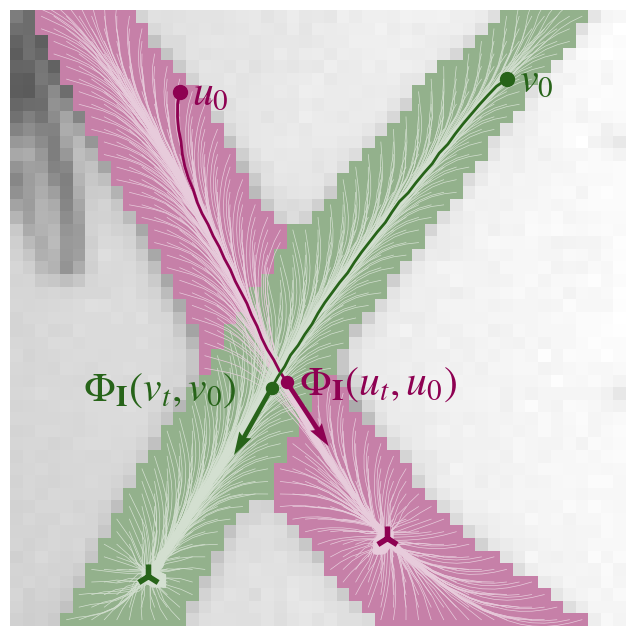

In [11]:
slicin = (slice(222,222+50),slice(105,105+50))
labels = [7,8]

new_mask = np.zeros_like(mask[slicin])
for i,l in enumerate(labels):
    new_mask[mask[slicin]==l] = i+1

one_hot_s = one_hot[[l-1 for l in labels]][:,slicin[0],slicin[1]]

outlines = {}
for i in range(2):
    # outlines[i] =skimage.segmentation.find_boundaries(new_mask==i,mode='thick')

    a,_ = cv2.findContours((one_hot_s[i]).astype(np.uint8),mode=cv2.RETR_TREE,method=cv2.CHAIN_APPROX_NONE)
    outlines[i] = a[0][:,0]
    print(outlines[i].shape)

u0_all =  np.array([[7,14],[6,40]])
n_steps = [25,31]

paths = {}
deltas = {}
for i in range(2):
    
    flow_i = flow[labels[i]-1][:,slicin[0],slicin[1]]
    u0 = u0_all[i]
    paths[i] = [u0]
    deltas[i] = []
    for t in range(n_steps[i]):
        delta = flow_i[:,u0[0].astype(np.uint),u0[1].astype(np.uint)]
        u0 = u0 + delta
        deltas[i].append(delta)
        paths[i].append(u0)


base_cmap = mpl.colormaps['PiYG'].resampled(256)
# newcolors = base_cmap(np.linspace(1, 1, 256))
# newcolors[0, :] = [1,1,1,1]
newcmp = ListedColormap([
    [1,1,1,0],base_cmap(0.0),base_cmap(1.0)
])

fade = 0.5
newcmp_faded = ListedColormap([
    [1,1,1,0],
    fade * np.array(base_cmap(0.0))+ (1-fade) * np.ones(4),
    fade * np.array(base_cmap(1.0))+ (1-fade) * np.ones(4)
])

# mask_rescaled = skimage.transform.rescale(new_mask,8,order=0)
n_steps = 20
many_paths = {}
for i in range(2):
    flow_i = flow[labels[i]-1][:,slicin[0],slicin[1]]
    u0 = np.stack(np.nonzero(new_mask==i+1),axis=0)
    n_pts = u0.shape[1]
    logs = np.empty((n_steps,2,n_pts))
    logs[0] = u0
    for t in range(1,n_steps):
        u0 = u0 + flow_i[:,u0[0].astype(np.uint),u0[1].astype(np.uint)]
        logs[t] = u0

    many_paths[i] = logs

# print(np.unique(mask[slicin]))
print(f"{new_mask.shape=}")
fig,axs = plt.subplots(1,1,figsize=(8,8))
axs.imshow(np.ones(new_mask.shape + (3,)))
axs.imshow(image[slicin],cmap='gray',alpha=0.8)
axs.imshow(new_mask,cmap=newcmp_faded)

# axs.imshow(dp_to_rgb(flow_i))
for i in range(2):

    col = newcmp(i+1)

    # axs.plot(outlines[i][::3,0],outlines[i][::3,1],color=col,linewidth=3,alpha=0.8)
    logs = many_paths[i]
    alpha = 0.2
    col2 = alpha * np.array(col) + (1-alpha) * np.array([1,1,1,1])
    axs.plot(logs[:,1,::1],logs[:,0,::1],color=col2,linewidth=0.5,zorder=1)

    p = np.stack(paths[i],axis=0)
    axs.plot(p[:,1],p[:,0],color=col,linewidth=2,zorder=2)
    axs.scatter(p[0,1],p[0,0],marker='.',s=400,color=col,zorder=2)
    axs.text(p[0,1]+1,p[0,0]+1,['$u_0$','$v_0$'][i],size=30,color=col,zorder=2)
    
    v = deltas[i][-1]
    axs.scatter(p[-1,1],p[-1,0],marker='.',s=300,color=col,zorder=2)
    axs.quiver(p[-1,1],p[-1,0],v[1],-v[0],color=col,scale=8,zorder=2)
    axs.text(p[-1,1]+[1,-15][i],p[-1,0]+1,
        [r'$\Phi_{\bf I}(u_t,u_0)$',r'$\Phi_{\bf I}(v_t,v_0)$'][i],
        size=30,color=col,zorder=2)
    
    axs.scatter([30.5,11.5][i],[42.5,45.5][i],marker='2',s=300,color=col,zorder=2,linewidth=4)
    
axs.set_xlim(0.5,49.5)
axs.set_ylim(49.5,0.5)
axs.set_axis_off()
fig.savefig(f'../figs/fig_1-ours.pdf',bbox_inches='tight',pad_inches=0)

In [13]:
from crossgoose.cellpose.dynamics import masks_to_flows_gpu
h,w = mask.shape
cp_flow = np.zeros((2,h,w))
for i in labels:
    m = mask == i
    m_closed = skimage.morphology.closing(m,skimage.morphology.disk(10))
    f = masks_to_flows_gpu(m_closed)[0]
    cp_flow[:,m] = f[:,m]

cp_flow = cp_flow[:,slicin[0],slicin[1]]

new_mask.shape=(50, 50)


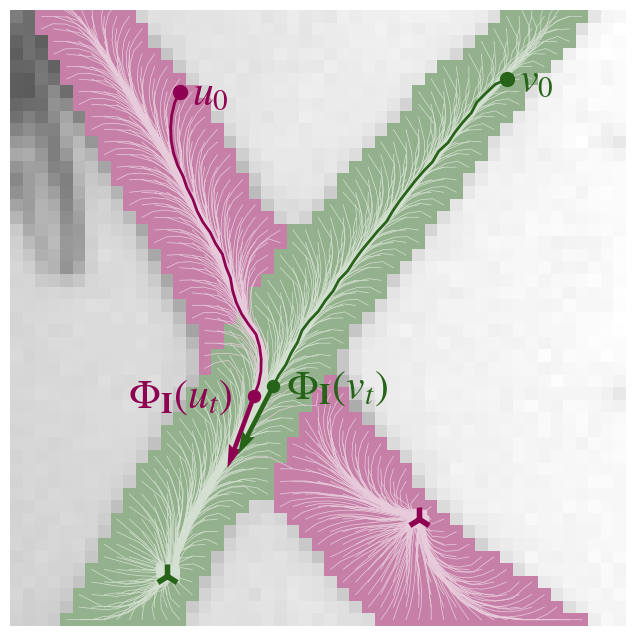

In [14]:
n_steps = [26,31]


paths = {}
deltas = {}
for i in range(2):
    
    u0 = u0_all[i]
    paths[i] = [u0]
    deltas[i] = []
    for t in range(n_steps[i]):
        delta = cp_flow[:,u0[0].astype(np.uint),u0[1].astype(np.uint)]
        u0 = u0 + delta
        deltas[i].append(delta)
        paths[i].append(u0)

colors = [
    ()
]


# mask_rescaled = skimage.transform.rescale(new_mask,8,order=0)
n_steps = 20
many_paths = {}
for i in range(2):
    u0 = np.stack(np.nonzero(new_mask==i+1),axis=0)
    n_pts = u0.shape[1]
    logs = np.empty((n_steps,2,n_pts))
    logs[0] = u0
    for t in range(1,n_steps):
        u0 = np.clip(u0 + cp_flow[:,u0[0].astype(np.uint),u0[1].astype(np.uint)],
                     np.array([[0],[0]]),np.array([[50],[50]])-1)
        logs[t] = u0

    many_paths[i] = logs

# print(np.unique(mask[slicin]))
print(f"{new_mask.shape=}")
fig,axs = plt.subplots(1,1,figsize=(8,8))
axs.imshow(np.ones(new_mask.shape + (3,)))
axs.imshow(image[slicin],cmap='gray',alpha=0.8)
axs.imshow(new_mask,cmap=newcmp_faded)
# axs.imshow(dp_to_rgb(flow_i))
for i in range(2):
    col = newcmp(i+1)

    logs = many_paths[i]
    alpha = 0.2
    col2 = alpha * np.array(col) + (1-alpha) * np.array([1,1,1,1])
    axs.plot(logs[:,1,::1],logs[:,0,::1],color=col2,linewidth=0.5,zorder=1)

    p = np.stack(paths[i],axis=0)
    axs.plot(p[:,1],p[:,0],color=col,linewidth=2,zorder=2)
    axs.scatter(p[0,1],p[0,0],marker='.',s=400,color=col,zorder=2)
    axs.text(p[0,1]+1,p[0,0]+1,['$u_0$','$v_0$'][i],size=30,color=col,zorder=2)
    
    v = deltas[i][-1]
    axs.scatter(p[-1,1],p[-1,0],marker='.',s=300,color=col,zorder=2)
    axs.quiver(p[-1,1],p[-1,0],v[1],-v[0],color=col,scale=8,zorder=2)
    axs.text(p[-1,1]+[-10,+1][i],p[-1,0]+1,
        [r'$\Phi_{\bf I}(u_t)$',r'$\Phi_{\bf I}(v_t)$'][i],
        size=30,color=col,zorder=2)
    
    axs.scatter([33,13][i],[41,45.5][i],marker='2',s=300,color=col,zorder=2,linewidth=4)
    
axs.set_xlim(0.5,49.5)
axs.set_ylim(49.5,0.5)
axs.set_axis_off()
fig.savefig(f'../figs/fig_1-cp.pdf',bbox_inches='tight',pad_inches=0)